In [9]:
# import torch
# from torch.utils.data import Dataset
# from PIL import Image
# import numpy as np
# from pycocotools.coco import COCO
# from torchvision import transforms
# import os
# from glob import glob


# class SegmentationDataset(Dataset):
#     def __init__(self, image_paths, annFile, transform=None, target_size=224, max_images = 2000):

#         self.image_paths = image_paths[:max_images]
#         self.transform = transform
#         self.target_size = target_size
#         self.coco = COCO(annFile)
#         # Map file name -> image_id
#         self.img_name_to_id = {img['file_name']: img['id'] for img in self.coco.dataset['images']}

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         img_path = self.image_paths[idx]
#         img = Image.open(img_path).convert("RGB")
#         w, h = img.size

#         # COCO image_id
#         file_name = os.path.basename(img_path)  # <-- 여기 수정
#         image_id = self.img_name_to_id[file_name]

#         # COCO annotations for this image
#         ann_ids = self.coco.getAnnIds(imgIds=image_id, catIds=[1])
#         anns = self.coco.loadAnns(ann_ids)

#         # Binary mask 생성
#         mask = Image.new('L', (w, h), 0)
#         for ann in anns:
#             rle = self.coco.annToMask(ann)
#             mask_array = np.array(mask)
#             mask_array[rle > 0] = 1
#             mask = Image.fromarray(mask_array)

#         # Resize
#         img = img.resize((self.target_size, self.target_size))
#         mask = mask.resize((self.target_size, self.target_size), resample=Image.NEAREST)

#         # Transform image
#         if self.transform:
#             img = self.transform(img)

#         # Mask to tensor
#         mask = torch.from_numpy(np.array(mask)).long()

#         return img, mask

# # Example usage
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
# ])

# # Example usage
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
# ])
# image_dir = 'data/images'
# image_paths = glob(os.path.join(image_dir, '*.jpg'))

# dataset = SegmentationDataset(
#     image_paths=image_paths,
#     annFile='data/annotations/instances_train2017.json',
#     transform=transform,
#     target_size=224,
#     max_images=2000
# )

# # 테스트
# img, mask = dataset[0]
# print(img.shape, mask.shape) 
# print(f'dataset size = {len(dataset)}')

In [10]:
import os
from torch.utils.data import Dataset
from PIL import Image
import torch

import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from pycocotools.coco import COCO
from torchvision import transforms
import os
from glob import glob


class SegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=224):
        """
        root_dir: data 폴더 경로
        transform: 이미지 변환(transform) 함수
        target_size: 이미지/마스크 resize 크기
        """
        self.image_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.transform = transform
        self.target_size = target_size

        # 이미지 파일 목록
        self.image_paths = sorted([
            os.path.join(self.image_dir, fname) 
            for fname in os.listdir(self.image_dir) 
            if fname.lower().endswith((".png", ".jpg", ".jpeg"))
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 이미지 불러오기
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        img = img.resize((self.target_size, self.target_size))

        # 마스크 불러오기 (이미지 파일 이름과 동일하다고 가정)
        mask_name = os.path.basename(img_path)
        mask_path = os.path.join(self.mask_dir, mask_name)
        mask = Image.open(mask_path).convert("L")  # 흑백
        mask = mask.resize((self.target_size, self.target_size), resample=Image.NEAREST)

        # transform 적용
        if self.transform:
            img = self.transform(img)

        # mask를 tensor로
        mask = torch.from_numpy(np.array(mask)).long()

        return img, mask

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = SegmentationDataset(root_dir="data/new", transform=transform, target_size=224)

# 첫 번째 샘플 확인
img, mask = dataset[1]
print(img.shape, mask.shape)
print(len(dataset))

torch.Size([3, 224, 224]) torch.Size([224, 224])
2667


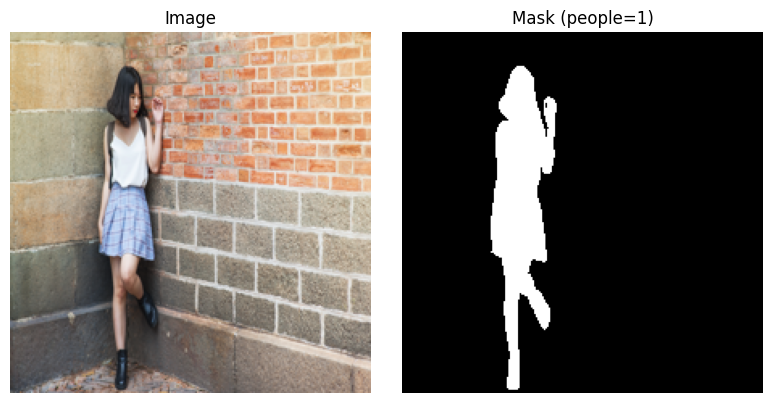

In [11]:
import matplotlib.pyplot as plt

# tensor -> numpy로 변환 (이미지는 [H,W,C]로)
img_np = img.permute(1, 2, 0).numpy()
# Normalize 되었다면 원래 색상 범위로 되돌리기
img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
img_np = np.clip(img_np, 0, 1)

mask_np = mask.numpy()

# 좌우 subplot
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(img_np)
axes[0].set_title("Image")
axes[0].axis("off")

axes[1].imshow(mask_np, cmap="gray")
axes[1].set_title("Mask (people=1)")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [12]:
from torchvision.models.segmentation import lraspp_mobilenet_v3_large, LRASPP_MobileNet_V3_Large_Weights

weights = LRASPP_MobileNet_V3_Large_Weights.DEFAULT
teacher = lraspp_mobilenet_v3_large(weights=weights)
teacher.eval()

trainable_params = sum(p.numel() for p in teacher.parameters() if p.requires_grad)
print("Teacher parameters:", trainable_params)


Teacher parameters: 3221538


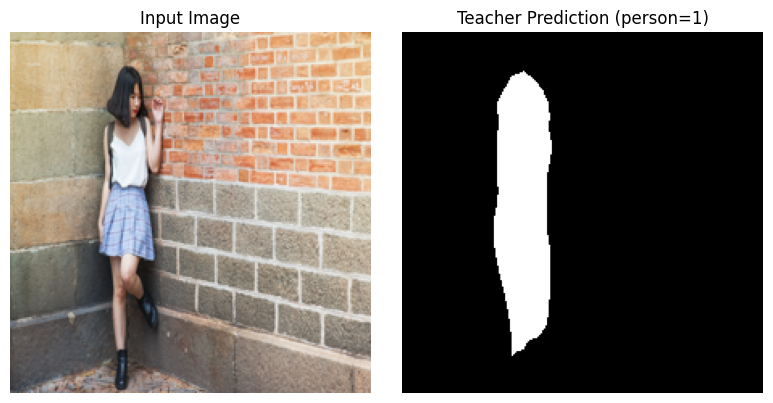

In [13]:
input_tensor = img.unsqueeze(0)

with torch.no_grad():
    output = teacher(input_tensor)['out']  # [1, num_classes, H, W]

# 4️⃣ 사람 클래스만 binary mask로 변환
# COCO pretrained DeepLabV3: person class = 15 (0~20)
person_class_id = 15
pred_mask = torch.argmax(output, dim=1).squeeze().cpu()
binary_mask = (pred_mask == person_class_id).long()  # 1=person, 0=others

# 5️⃣ 시각화
img_np = img.permute(1,2,0).numpy()
img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
img_np = np.clip(img_np, 0, 1)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(binary_mask.numpy(), cmap="gray")
plt.title("Teacher Prediction (person=1)")
plt.axis("off")
plt.tight_layout()
plt.show()

In [14]:
from unet.unet_model import UNet

student = UNet(channel_depth=16, n_channels=3, n_classes=1)
''
trainable_params = sum(p.numel() for p in student.parameters() if p.requires_grad)
print("Student parameters:", trainable_params)

Student parameters: 839777


In [15]:
import numpy as np
from loss import loss_fn_kd
from metrics import dice_loss
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from tqdm.auto import tqdm



def fetch_teacher_outputs(teacher, train_loader, person_class_id=15):
    print('-------Fetch teacher outputs (person only)-------')

    teacher = teacher.eval().cuda()
    teacher_outputs = []

    with torch.no_grad():
        for i, (img, gt) in enumerate(train_loader):
            print(i, 'batch')

            img = img.cuda()

            # teacher forward
            out = teacher(img)["out"]  # [B, C, H, W]

            # person logit만 선택 → [B,1,H,W]
            person_logit = out[:, person_class_id:person_class_id+1, :, :]

            # CPU로 모아서 저장
            teacher_outputs.append(person_logit.cpu())

    return teacher_outputs


def evaluate_kd(student, val_loader):
    print('-------Evaluate student-------')
    student.eval().cuda()

    #criterion = torch.nn.BCEWithLogitsLoss()
    loss_summ = []
    with torch.no_grad():
        for i, (img, gt) in enumerate(val_loader):
            if torch.cuda.is_available():
                img, gt = img.cuda(), gt.cuda()
            img, gt = Variable(img), Variable(gt)

            output = student(img)
            output = output.clamp(min = 0, max = 1)
            loss = dice_loss(output, gt)

            loss_summ.append(loss.item())

    mean_loss = np.mean(loss_summ)
    print('- Eval metrics:\n\tAverage Dice loss:{}'.format(mean_loss))
    return mean_loss

min_loss = 100





#2 tensors -> img_list and gt_list. for batch_size = 1 --> img: (1, 3, 320, 320); gt: (1, 1, 320, 320)
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size = 1
)
teacher_outputs = fetch_teacher_outputs(teacher, train_loader)
print(len(teacher_outputs))



-------Fetch teacher outputs (person only)-------
0 batch
1 batch
2 batch
3 batch
4 batch
5 batch
6 batch
7 batch
8 batch
9 batch
10 batch
11 batch
12 batch
13 batch
14 batch
15 batch
16 batch
17 batch
18 batch
19 batch
20 batch
21 batch
22 batch
23 batch
24 batch
25 batch
26 batch
27 batch
28 batch
29 batch
30 batch
31 batch
32 batch
33 batch
34 batch
35 batch
36 batch
37 batch
38 batch
39 batch
40 batch
41 batch
42 batch
43 batch
44 batch
45 batch
46 batch
47 batch
48 batch
49 batch
50 batch
51 batch
52 batch
53 batch
54 batch
55 batch
56 batch
57 batch
58 batch
59 batch
60 batch
61 batch
62 batch
63 batch
64 batch
65 batch
66 batch
67 batch
68 batch
69 batch
70 batch
71 batch
72 batch
73 batch
74 batch
75 batch
76 batch
77 batch
78 batch
79 batch
80 batch
81 batch
82 batch
83 batch
84 batch
85 batch
86 batch
87 batch
88 batch
89 batch
90 batch
91 batch
92 batch
93 batch
94 batch
95 batch
96 batch
97 batch
98 batch
99 batch
100 batch
101 batch
102 batch
103 batch
104 batch
105 batch


In [16]:
def train_student(student, teacher_outputs, optimizer, train_loader):
    print('-------Train student-------')
    #called once for each epoch
    student.train().cuda()

    summ = []
    for i,(img, gt) in enumerate(train_loader):
        print(i)
        teacher_output = teacher_outputs[i]['out']
        if torch.cuda.is_available():
            img, gt = img.cuda(), gt.cuda()
            teacher_output = teacher_output.cuda()

        img, gt = Variable(img), Variable(gt)
        teacher_output =  Variable(teacher_output)

        output = student(img)

        #TODO: loss is wrong
        loss = loss_fn_kd(output, teacher_output, gt)    

        # clear previous gradients, compute gradients of all variables wrt loss
        optimizer.zero_grad()
        loss.backward()

        # performs updates using calculated gradients
        optimizer.step()
        if i % summary_steps == 0:
            #do i need to move it to CPU?
            
            metric = dice_loss(output, gt)
            summary = {'metric' : metric.item(), 'loss' : loss.item()}
            summ.append(summary)
    
    #print('Average loss over this epoch: ' + np.mean(loss_avg))
    mean_dice_coeff =  np.mean([x['metric'] for x in summ])
    mean_loss = np.mean([x['loss'] for x in summ])
    print('- Train metrics:\n' + '\tMetric:{}\n\tLoss:{}'.format(mean_dice_coeff, mean_loss))
    #print accuracy and loss


num_of_epochs = 10
summary_steps = 10
optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)
# scheduler = StepLR(optimizer, step_size = 5000, gamma = 0.2)


for epoch in range(num_of_epochs):
    #train the student
    print(' --- student training: epoch {}'.format(epoch+1))
    train_student(student, teacher_outputs, optimizer, train_loader)
    torch.save(student.state_dict(), f'checkpoints/0.9/16/CP{epoch}.pth'.format(epoch+1))
    print("Checkpoint {} saved!".format(epoch+1))


 --- student training: epoch 1
-------Train student-------
0


TypeError: new(): invalid data type 'str'

In [ ]:
torch.save(student.state_dict(), "student_model.pth")

In [ ]:
model = UNet(channel_depth=16, n_channels=3, n_classes=1)    # 모델 구조 먼저 생성
model.load_state_dict(torch.load("student_model.pth"))
model.eval()

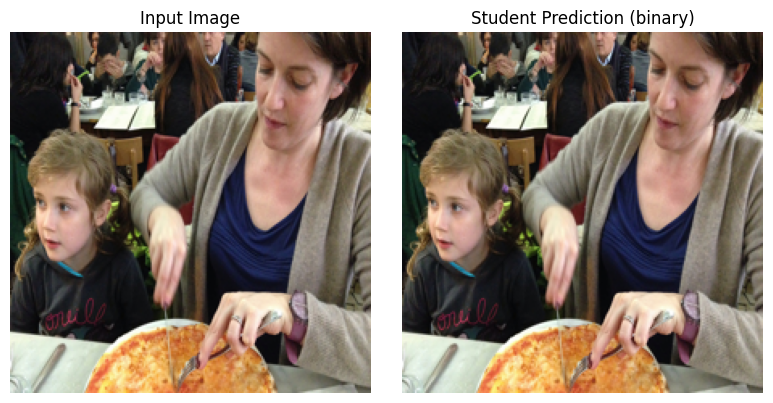

In [ ]:
input_tensor = img.unsqueeze(0).cuda()

with torch.no_grad():
    student_mask = student(input_tensor)  # [1, 1, H, W]
    student_mask = (student_mask > 0.5).float().squeeze().cpu()  # [H, W]

# 원본 이미지 처리 (normalize 해제)
img_np = input_tensor.squeeze().permute(1,2,0).cpu().numpy()
img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
img_np = np.clip(img_np, 0, 1)

# 시각화
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_np*student_mask.unsqueeze(-1).numpy(), cmap="gray")
plt.title("Student Prediction (binary)")
plt.axis("off")

plt.tight_layout()
plt.show()